# User Profile Data Prep

This notebook does the data preparation for Bayesian inference for the model analysis.

## Setup

In [1]:
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotnine import *
import ujson

In [3]:
from bookgender.config import data_dir
from bookgender.nbutils import *

In [4]:
fig_dir = init_figs('ProfileData')

using figure dir figures/ProfileData


## Load Data

We need to load the author-gender information:

In [5]:
book_gender = pd.read_csv(data_dir / 'author-gender.csv.gz')
book_gender = book_gender.set_index('item')['gender']
book_gender.describe()

count     12234574
unique           6
top           male
freq       3645216
Name: gender, dtype: object

In [6]:
book_gender[book_gender == 'no-viaf-author'] = 'unlinked'
book_gender[book_gender == 'no-loc-author'] = 'unlinked'
book_gender[book_gender == 'no-loc-book'] = 'unlinked'
book_gender = book_gender.astype('category')
book_gender.unique()

[male, unlinked, female, unknown, ambiguous]
Categories (5, object): [male, unlinked, female, unknown, ambiguous]

And we load book hashes, to set up our dummy bias:

In [7]:
book_hash = pd.read_parquet(data_dir / 'book-hash.parquet').rename(columns={'cluster': 'item'})
book_hash['dcode'] = book_hash['md5'].apply(lambda x: int(x[-1], 16) % 2)
book_hash = book_hash.set_index('item')
book_hash.head()

,nisbns,md5,dcode
item,,,
0,17,3781b82fabd530590c70cac955b52bb0,0
1,2,4c6606ab43bfbe946a436c0ce7633a7a,0
2,38,e16249d40bf94b35d8a784d73d0511c5,1
3,2,289071ab1041c090ac252616a76fe079,1
4,4,7308735b39347b616ee6be0ab093541e,0


Load the sample user ratings for each data set:

In [8]:
user_ratings = pd.read_csv(data_dir / 'study-ratings.csv')
user_ratings.drop(columns=['rating'], inplace=True)
user_ratings.rename(columns={'dataset': 'Set'}, inplace=True)
user_ratings.head()

,Set,user,item,timestamp,nactions,first_time,last_time
0,AZ,4975592,462114,1.233101e+09,NaN,NaN,NaN
1,AZ,4975592,1662785,1.233101e+09,NaN,NaN,NaN
2,AZ,4975592,7287509,1.233101e+09,NaN,NaN,NaN
3,AZ,4975592,8866889,1.233101e+09,NaN,NaN,NaN
4,AZ,4975592,10031188,1.233101e+09,NaN,NaN,NaN


In [9]:
user_ratings = user_ratings.join(book_gender, on='item', how='left')
user_ratings['gender'].fillna('unlinked', inplace=True)
user_ratings = user_ratings.join(book_hash['dcode'], on='item', how='left')
user_ratings.head(15)

,Set,user,item,timestamp,nactions,first_time,last_time,gender,dcode
0,AZ,4975592,462114,1.233101e+09,NaN,NaN,NaN,male,0.0
1,AZ,4975592,1662785,1.233101e+09,NaN,NaN,NaN,male,1.0
2,AZ,4975592,7287509,1.233101e+09,NaN,NaN,NaN,male,1.0
3,AZ,4975592,8866889,1.233101e+09,NaN,NaN,NaN,unknown,0.0
4,AZ,4975592,10031188,1.233101e+09,NaN,NaN,NaN,male,0.0
5,AZ,4975592,43930,1.233274e+09,NaN,NaN,NaN,male,1.0
6,AZ,4975592,11005013,1.233274e+09,NaN,NaN,NaN,unknown,1.0
7,AZ,4975592,3649898,1.233619e+09,NaN,NaN,NaN,male,1.0
8,AZ,4975592,8462465,1.233619e+09,NaN,NaN,NaN,male,0.0
9,AZ,4975592,3727790,1.234656e+09,NaN,NaN,NaN,male,0.0


Now we will summarize user profiles:

In [10]:
def summarize_profile(df):
    gender = df['gender']
    dc = df['dcode']
    data = {
        'count': len(df),
        'linked': np.sum(gender != 'unlinked'),
        'ambiguous': np.sum(gender == 'ambiguous'),
        'male': np.sum(gender == 'male'),
        'female': np.sum(gender == 'female'),
        'dcknown': dc.count(),
        'dcyes': dc.sum(skipna=True),
        'PropDC': dc.mean()
    }
    data['Known'] = data['male'] + data['female']
    data['PropFemale'] = data['female'] / data['Known']
    data['PropKnown'] = data['Known'] / data['count']
    return pd.Series(data)

In [11]:
profiles = user_ratings.groupby(['Set', 'user']).apply(summarize_profile)
profiles = profiles.apply(lambda s: s if s.name.startswith('Prop') else s.astype('i4'))
profiles.head()

count  linked  ambiguous  male  female  dcknown  dcyes    PropDC  \
Set user                                                                     
AZ  529       8       8          2     1       4        8      3  0.375000   
    1723     25      24          3    15       6       25     14  0.560000   
    1810     14       6          0     6       0        8      1  0.125000   
    2781      8       8          1     5       1        8      5  0.625000   
    2863      6       6          0     6       0        6      4  0.666667   

          Known  PropFemale  PropKnown  
Set user                                
AZ  529       5    0.800000   0.625000  
    1723     21    0.285714   0.840000  
    1810      6    0.000000   0.428571  
    2781      6    0.166667   0.750000  
    2863      6    0.000000   1.000000

How are profile sizes distributed?

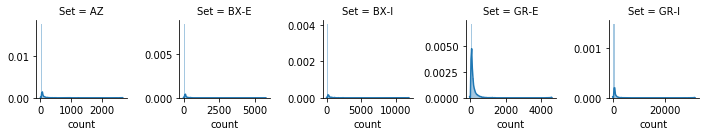

In [12]:
g = sns.FacetGrid(profiles.reset_index(), col='Set', sharex=False, sharey=False, height=2)
g.map(sns.distplot, 'count')
plt.savefig(fig_dir / 'profile-size-all.pdf')

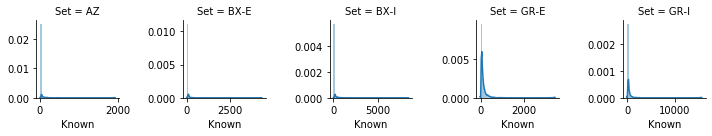

In [13]:
g = sns.FacetGrid(profiles.reset_index(), col='Set', sharex=False, sharey=False, height=2)
g.map(sns.distplot, 'Known')
plt.savefig(fig_dir / 'profile-size-known.pdf')

For the paper, we want to make some changes - we're going to show this on a scatter plot.

In [14]:
up_sizes = profiles[['count', 'Known']].reset_index().melt(id_vars=['Set', 'user'], var_name='Type', value_name='Size')
up_sizes['Type'] = up_sizes['Type'].astype('category').cat.rename_categories({
    'count': 'All',
    'Known': 'Known-Gender'
})
up_sizes.head()

,Set,user,Type,Size
0,AZ,529,All,8
1,AZ,1723,All,25
2,AZ,1810,All,14
3,AZ,2781,All,8
4,AZ,2863,All,6


In [15]:
size_counts = up_sizes.groupby(['Set', 'Type', 'Size'])['user'].count().reset_index(name='Users')
size_counts = size_counts[size_counts['Users'] > 0]
size_counts.head()

,Set,Type,Size,Users
0,AZ,Known-Gender,5,1300
1,AZ,Known-Gender,6,829
2,AZ,Known-Gender,7,572
3,AZ,Known-Gender,8,416
4,AZ,Known-Gender,9,284


In [16]:
size_counts['Users'].describe()

count    4202.000000
mean       11.899096
std        46.498697
min         1.000000
25%         1.000000
50%         2.000000
75%         7.000000
max      1300.000000
Name: Users, dtype: float64

/home/MICHAELEKSTRAND/anaconda3/envs/bookfair/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 7 x 3.2 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/MICHAELEKSTRAND/anaconda3/envs/bookfair/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: figures/ProfileData/profile-size.pdf
  warn('Filename: {}'.format(filename), PlotnineWarning)


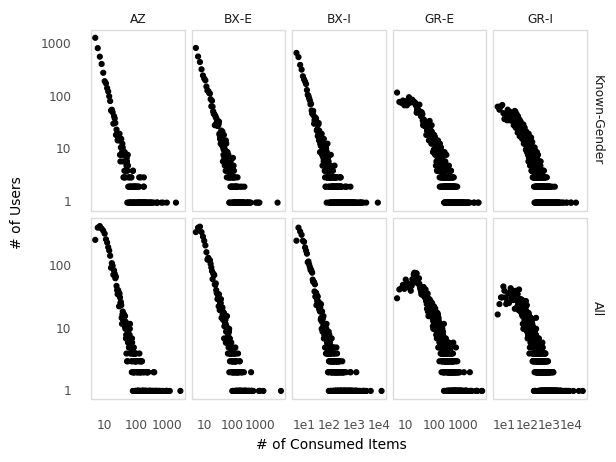

<ggplot: (8782675280353)>

In [17]:
make_plot(size_counts, aes(x='Size', y='Users'),
          geom_point(),
          scale_x_log10(),
          scale_y_log10(),
          facet_grid('Type ~ Set', scales='free'),
          xlab('# of Consumed Items'),
          ylab('# of Users'),
          panel_grid=element_blank(),
          file='profile-size.pdf', width=7, height=3.2)

And % known?

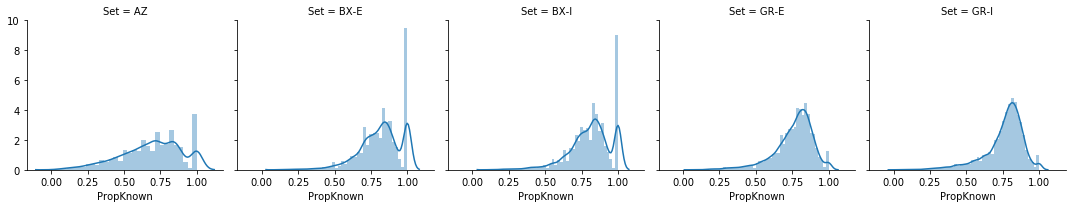

In [18]:
g = sns.FacetGrid(profiles.reset_index(), col='Set')
g.map(sns.distplot, 'PropKnown')

## Distribution of Female Authors

Quick empirical inspection:

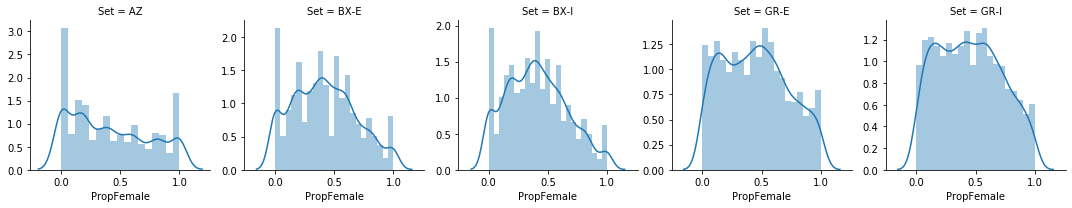

In [19]:
g = sns.FacetGrid(profiles.reset_index(), col='Set', sharey=False)
g.map(sns.distplot, 'PropFemale')

In [20]:
profiles.groupby('Set')['PropFemale'].mean()

Set
AZ      0.414445
BX-E    0.418886
BX-I    0.407030
GR-E    0.446998
GR-I    0.450201
Name: PropFemale, dtype: float64

In [21]:
np.sqrt(profiles.groupby('Set')['PropFemale'].var())

Set
AZ      0.329436
BX-E    0.267354
BX-I    0.254304
GR-E    0.276480
GR-I    0.269127
Name: PropFemale, dtype: float64

## Distribution of Dummy Codes

Quick empirical inspection - this should be noise:

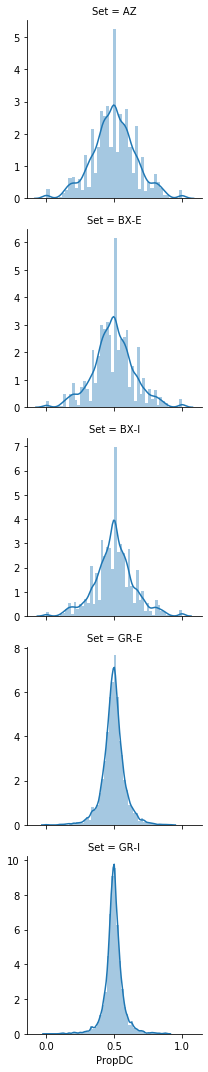

In [22]:
g = sns.FacetGrid(profiles.reset_index(), row='Set', sharey=False)
g.map(sns.distplot, 'PropDC')

## Saving Outputs

We save profile data frame to be reloaded in the Bayesian analysis.

In [23]:
profiles.to_pickle('data/profile-data.pkl')

We also want to save the data for STAN.

In [24]:
def stan_inputs(data, kc, pc):
    return {
        'J': len(data),
        'n': data[kc],
        'y': data[pc]
    }

In [25]:
def inf_dir(sname):
    return data_dir / sname / 'inference'

In [26]:
for sname, frame in profiles.groupby('Set'):
    print('preparing STAN input for', sname)
    dir = inf_dir(sname)
    dir.mkdir(exist_ok=True)
    in_fn = dir / 'profile-inputs.json'
    in_fn.write_text(ujson.dumps(stan_inputs(frame, 'Known', 'female')))
    in_fn = dir / 'profile-dcode-inputs.json'
    in_fn.write_text(ujson.dumps(stan_inputs(frame, 'dcknown', 'dcyes')))

preparing STAN input for AZ
preparing STAN input for BX-E
preparing STAN input for BX-I
preparing STAN input for GR-E
preparing STAN input for GR-I
